In [1]:
import math, sys 
import numpy as np
import sympy as sp
from scipy import sparse
from sympy import fourier_series, pi
from scipy.fftpack import *
from scipy.sparse import diags
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from os import path

In [17]:
#Heat Diffusion in one dimensional wire within the Explicit Method
"""
F(x) = SUM (80/(pi*(2k+1))**2) * sin((2k+1)*pi*x) * e**(-.25*t*((2k+1)*pi)**2)
"""    
#Heat function exact solution
def HeatSolution(x, t):
    return (((80/(math.pi)**2) * np.sin(math.pi*x) * np.exp(-.25*t*math.pi**2)) + 
            ((80/(math.pi*3)**2) * np.sin(3*math.pi*x) * np.exp(-.25*t*(3*math.pi)**2)) + 
            ((80/(math.pi*5)**2) * np.sin(5*math.pi*x) * np.exp(-.25*t*(5*math.pi)**2)) + 
            ((80/(math.pi*5)**2) * np.sin(5*math.pi*x) * np.exp(-.25*t*(5*math.pi)**2)) + 
            ((80/(math.pi*7)**2) * np.sin(7*math.pi*x) * np.exp(-.25*t*(7*math.pi)**2)))


In [93]:
# ---- Surface plot ----
def surfaceplot(U, tspan, xspan, title): 
    M = (int) (1 / (0.1))
    N = (int) (2 / (0.1)) #GRID POINTS on time interval
    
    #meshgrid : Return coordinate matrices from coordinate vectors
    X, T = np.meshgrid(tspan, xspan)
    
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, T, U, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Space')
    ax.set_zlabel('U')
    
    plt.tight_layout()
    ax.view_init(30,230)
    
    plt.savefig(title)
    plt.draw()
    

In [94]:
'''
Exact Solution for 1D reaction-diffusion equation:
        u_t = 0.25 * u_xx
    
with boundary conditions 
at x=0: u_x(0,t) = 0
at x=L: u_x(L,t) = 0

with L = 1 and initial conditions:
u(x,0) = 20x, 0 <= x <= 1/2 || 20(1-x), 1/2 <= x <= 1
'''

def ExactSolutionHeat(T = 2, L = 1):
    #GRID POINTS on time interval
    M = (int) (L / (0.1))
    N = (int) (T / (0.1)) #GRID POINTS on time interval

    xspan = np.linspace(0, L, M)
    tspan = np.linspace(0, T, N)
    
    Uexact = np.zeros((M, N))
    
    for i in range(0, M):
        for j in range(0, N):
            Uexact[i][j] = HeatSolution(xspan[i], tspan[j])
    
    return (Uexact, tspan, xspan)

In [95]:
'''
Crank-Nicolson method to solve 1D reaction-diffusion equation:
        u_t = 0.25 * u_xx
    
with boundary conditions 
at x=0: u(0,t) = 0
at x=1: u(1,t) = 0

want initial conditions:
u(x,0) = 20x, 0 <= x <= 1/2 || 20(1-x), 1/2 <= x <= 1
'''
def CrankNicolson(T, L, k):
    #Parameters needed to solve the equation within the explicit method
    # M = GRID POINTS on space interval
    M = (int) (L / (0.1))
    N = (int) (T / (0.1)) #GRID POINTS on time interval

    # ---- Length of the wire in x direction ---- 
    x0, xL = 0, L
    dx = (xL - x0)/(M)

    # ---- Final time ---- 
    t0, tF = 0, T 
    dt = (tF - t0)/(N)

    lambd = dt*k/(2.0*dx**2)
    a0 = 1 + 2*lambd
    c0 = 1 - 2*lambd

    xspan = np.linspace(x0, xL, M)
    tspan = np.linspace(t0, tF, N)

    maindiag_a0 = a0*np.ones((1,M))
    offdiag_a0 = (-lambd)*np.ones((1, M-1))

    maindiag_c0 = c0*np.ones((1,M))
    offdiag_c0 = lambd*np.ones((1, M-1))

    #Left-hand side tri-diagonal matrix
    a = maindiag_a0.shape[1]
    diagonalsA = [maindiag_a0, offdiag_a0, offdiag_a0]
    A = sparse.diags(diagonalsA, [0,-1,1], shape=(a,a)).toarray()
    
    #Right-hand side tri-diagonal matrix
    c = maindiag_c0.shape[1]
    diagonalsC = [maindiag_c0, offdiag_c0, offdiag_c0]
    
    Arhs = sparse.diags(diagonalsC, [0,-1,1], shape=(c,c)).toarray()

    # ----- Initializes matrix U -----
    U = np.zeros((M, N))

    #----- Initial condition -----
    U[:,0] = np.piecewise(xspan, [xspan < 0.5, xspan >= 0.5], 
                          [lambda x: 20*x, lambda x: 20-20*x])
    
    for k in range(1,N):
        intermed = np.matmul(np.linalg.inv(A), Arhs)
        U[0:M, k] = np.matmul(intermed, U[0:M, k-1])
    
    return (U, tspan, xspan)

In [96]:
U, tspan, xspan = CrankNicolson(T=2, L=1, k=0.25)

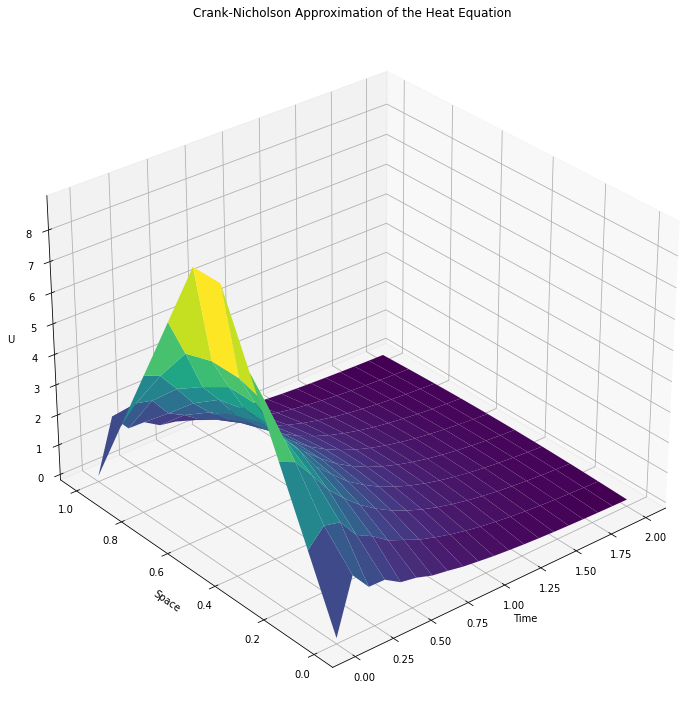

In [97]:
surfaceplot(U, tspan, xspan, "Crank-Nicholson Approximation of the Heat Equation")

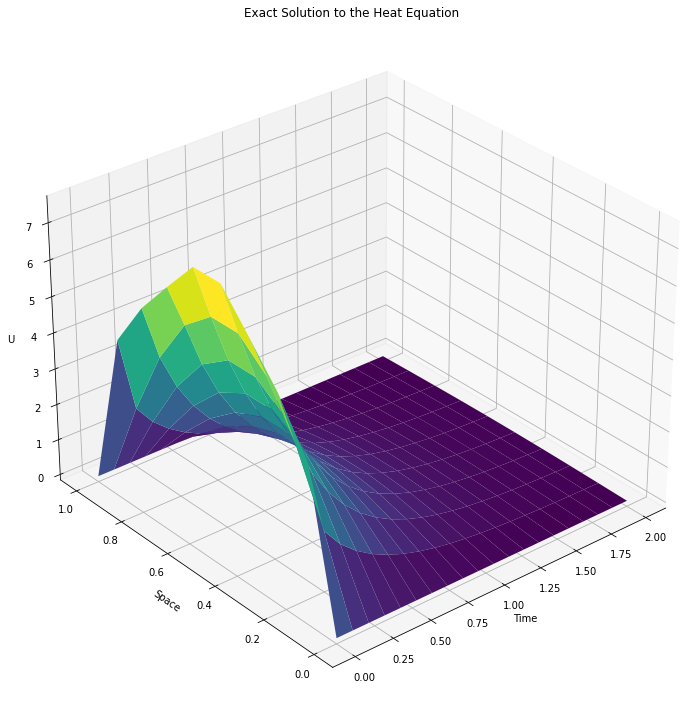

In [98]:
Uexact, x, t = ExactSolutionHeat()
surfaceplot(Uexact, tspan, xspan, "Exact Solution to the Heat Equation")

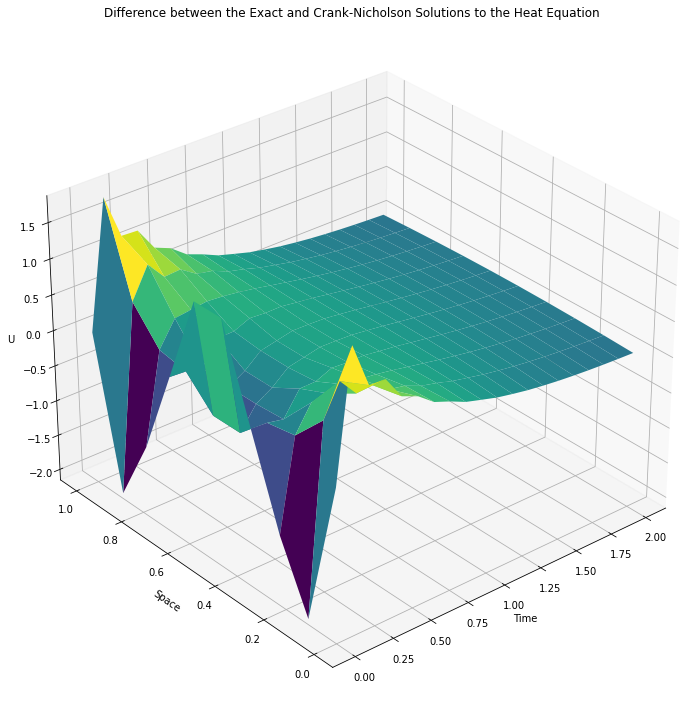

In [99]:
U - Uexact
surfaceplot(U-Uexact, tspan, xspan, "Difference between the Exact and Crank-Nicholson Solutions to the Heat Equation")

In [100]:
h = 0.1
tau = 0.1

def f(x):
    return x*(1-x)

# u_tt(xi,0) = c^2(f(ih) - 2f((i-1)h) + f((i-2)h))/h^2
# c = 1
def ftt(i):
#     return (f((i+1)*h)-2*f(i*h)+f((i-1)*h))/(h**2)
    return (f((i)*h)-2*f((i-1)*h)+f((i-2)*h))/(h**2)

# u_i,2 = u_i,1 + tau^2 u_tt(xi,0) / 2
# g(x) = 0
def f2(i, U):
    return U[i,0] + (tau**2)*ftt(i)/2

In [101]:
'''
Implicit method to solve wave equation:
        u_tt = u_xx
    
with boundary conditions 
0 < t <= 2, 0 < x < 1
at x=0: u(0,t) = 0
at x=1: u(1,t) = 0
at x=0: u_t(x,0) = 0 = g(x)

want initial conditions:
u(x,0) = x(1-x) = f(x)
'''

def implicit(L=1, T=2):
    #Parameters needed to solve the equation within the explicit method
    # M = GRID POINTS on space interval
    M = (int) (L / (0.1))
    N = (int) (T / (0.1)) #GRID POINTS on time interval

    x0, xL = 0, L
    h = (xL - x0)/(M)

    # ---- Final time ---- 
    t0, tF = 0, T 
    tau = (tF - t0)/(N)

    mSq = ((tau*1/h)**2)

    xspan = np.linspace(x0, xL, M)
    tspan = np.linspace(t0, tF, N)

    maindiag = (2*(1+mSq))*np.ones((1,M-1))
    offdiag = (-1*mSq)*np.ones((1, M-1))

    a = maindiag.shape[1]
    diagonalsA = [maindiag, offdiag, offdiag]
    A = sparse.diags(diagonalsA, [0,-1,1], shape=(a,a)).toarray()
    AInv = np.linalg.inv(A)

    # ----- Initializes matrix U -----
    U = np.zeros((M, N))

    #----- Initial condition -----
    U[1:M-1,0] = np.array([f((i)*h) for i in range(1,M-1)])
    U[1:M-1,1] = np.array([f2(i, U) for i in range(1,M-1)])

    for k in range(3,N):
        U[1:M, k] = 4*np.matmul(AInv, U[1:M, k-1]) - U[1:M,k-2]
    
    return (U, tspan, xspan)

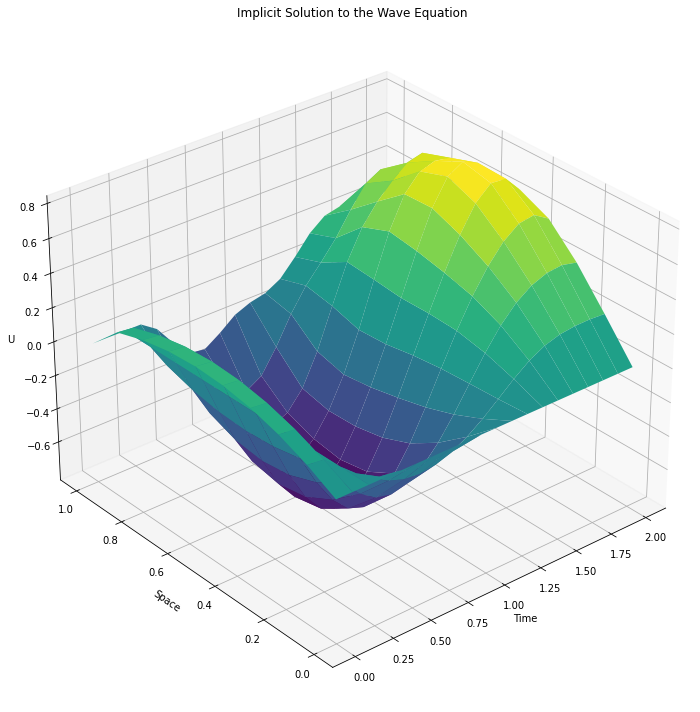

In [102]:
(U, tspan, xspan) = implicit()
surfaceplot(U, tspan, xspan, "Implicit Solution to the Wave Equation")

In [103]:
# Wave Diffusion in one dimensional wire within the Explicit Method
"""
By the d'Alembert solution to the wave equation, the solution is
u(t,x) = (S_f,s(x+ct) + S_f,s(x-ct))/2
"""    
c = 1
pi = math.pi
def WaveSolution(x, t):
    return 4*((np.sin(pi*(x+c*t))+np.sin(pi*(x-c*t)))/1 + 
              (np.sin(3*pi*(x+c*t))+np.sin(3*pi*(x-c*t)))/27 + 
              (np.sin(5*pi*(x+c*t))+np.sin(5*pi*(x-c*t)))/125 + 
              (np.sin(7*pi*(x+c*t))+np.sin(7*pi*(x-c*t)))/343)/(pi**3)


In [104]:
'''
Exact Solution for:
        u_tt = u_xx
    
with boundary conditions 
at x=0: u_x(0,t) = 0
at x=L: u_x(L,t) = 0
u_t(x,0) = 0
with L = 1

u(x,0) = x(1-x)
'''

def ExactSolutionWave(T = 2, L = 1):
    #GRID POINTS on time interval
    M = (int) (L / (0.1))
    N = (int) (T / (0.1)) #GRID POINTS on time interval

    xspan = np.linspace(0, L, M)
    tspan = np.linspace(0, T, N)
    
    Uexact = np.zeros((M, N))
    
    for i in range(0, M):
        for j in range(0, N):
            Uexact[i][j] = WaveSolution(xspan[i], tspan[j])
    
    return (Uexact, tspan, xspan)

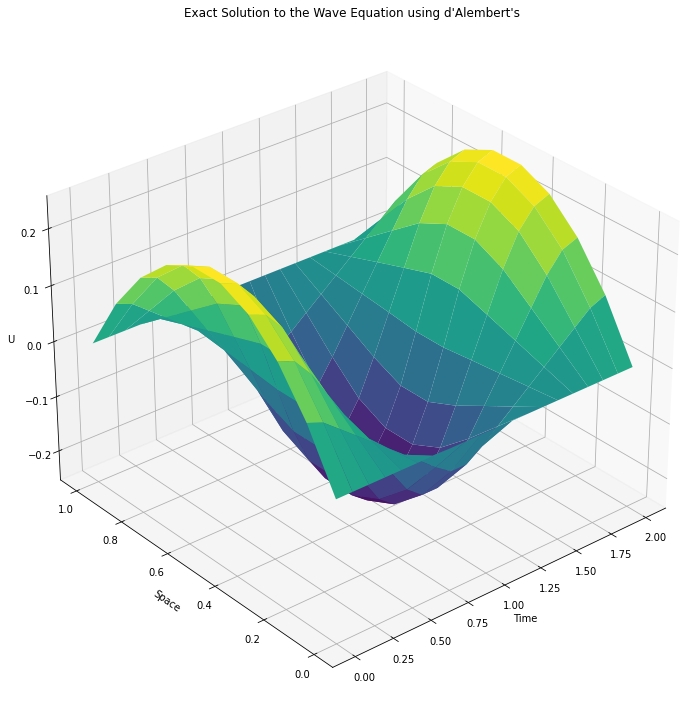

In [105]:
(Uexact, tspan, xspan) = ExactSolutionWave()
surfaceplot(Uexact, tspan, xspan, "Exact Solution to the Wave Equation using d'Alembert's")

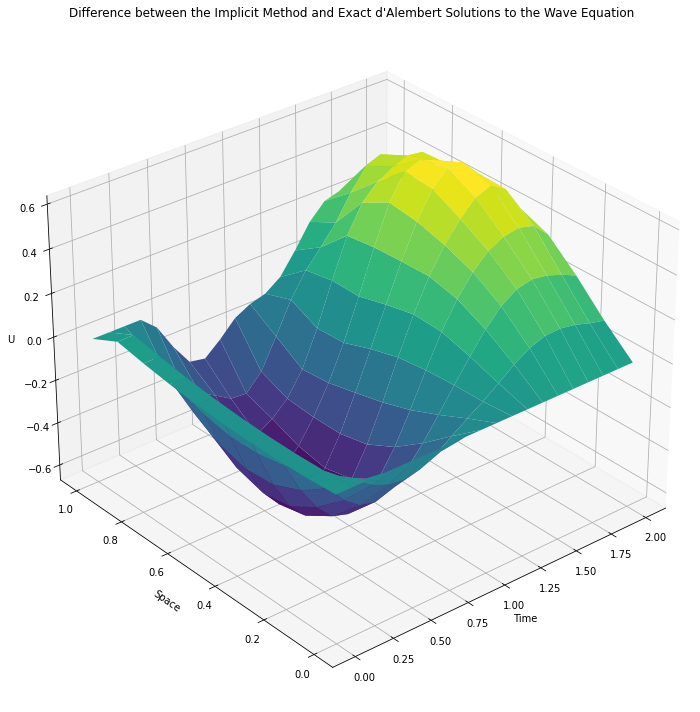

In [106]:
surfaceplot(U-Uexact, tspan, xspan, 
            "Difference between the Implicit Method and Exact d'Alembert Solutions to the Wave Equation")

In [77]:
print((U-Uexact)[:,-1])

[0.         0.08105778 0.16405989 0.24339684 0.31104976 0.36933187
 0.42818511 0.48642224 0.52246167 0.52495247 0.52068194 0.52994828
 0.51831789 0.47206792 0.44383119 0.41101623 0.33200161 0.2794876
 0.205403   0.12720563]
